# Stochastic Gradient Descent (SGD) Regressor

- [Baseline SGDR](#BSGDR)
- [Step-Wise Training of SGDR](#"SWTSGDR")
- [Finding the Best eta0](#FETA0)
- [SGD Regressors With Different Types of Learning Rate](#SGDRLR)

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import SGDRegressor

from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, learning_curve, ShuffleSplit, validation_curve

from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

np.random.seed(306)
plt.style.use('seaborn')

In [9]:
features, labels = fetch_california_housing(as_frame=True, return_X_y=True)
print("Shape of feature matrix is : ", features.shape)
print("Shape of label vector is : ", labels.shape)

com_train_features, test_features, com_train_labels, test_labels = train_test_split(features, labels, random_state=42)
print("\nComplete training samples : ", com_train_features.shape)
print("Test samples : ", test_features.shape)

Shape of feature matrix is :  (20640, 8)
Shape of label vector is :  (20640,)

Complete training samples :  (15480, 8)
Test samples :  (5160, 8)


**Complete training set is further divided into *train* and *dev* (used to tune hyper-parameters)**

In [10]:
train_features, dev_features, train_labels, dev_labels = train_test_split(com_train_features, com_train_labels, random_state=42)
print("Training samples : ", train_features.shape)
print("Dev samples : ", dev_features.shape)
print("Test samples : ", test_features.shape)

Training samples :  (11610, 8)
Dev samples :  (3870, 8)
Test samples :  (5160, 8)


## <a id="BSGDR"></a>Baseline SGDRegressor

In [19]:
sgd = SGDRegressor(random_state=42)
sgd.fit(train_features, train_labels)

y_train = train_labels
y_dev = dev_labels
y_pred_train = sgd.predict(train_features)
y_pred_dev = sgd.predict(dev_features)

train_mae = mean_absolute_error(y_train, y_pred_train)
dev_mae = mean_absolute_error(y_dev, y_pred_dev)

print(train_mae, dev_mae)

309190327803747.2 311959782899622.1


Errors are too high, perhaps due to large learning rate. Let's try with a feature scaling step before fitting the model

In [12]:
sgd_pipeline = Pipeline([("feature_scaling", StandardScaler()),
                             ("sgd", SGDRegressor(random_state=42))])

In [20]:
sgd_pipeline.fit(train_features, train_labels)

y_train = train_labels
y_dev = dev_labels
y_pred_train = sgd_pipeline.predict(train_features)
y_pred_dev = sgd_pipeline.predict(dev_features)

train_mae = mean_absolute_error(y_train, y_pred_train)
dev_mae = mean_absolute_error(y_dev, y_pred_dev)

print(train_mae, dev_mae)

0.7263733471565367 1.0129611556669136


## <a id="SWTSGDR"></a>Step-Wise Training of SGDRegressor

In [28]:
eta0 = 1e-2
sgd_pipeline = Pipeline([("feature_scaling", StandardScaler()), ("sgd", SGDRegressor(max_iter=1, warm_start=True, random_state=42))])

Text(0.5, 1.0, 'Learning curve : eta0=0.01')

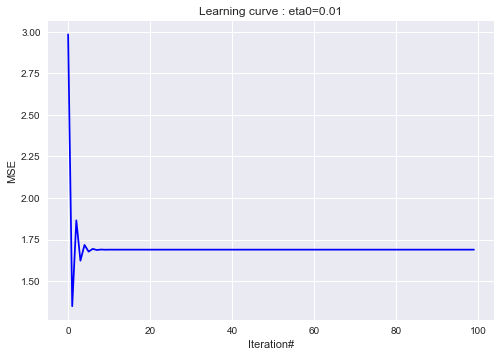

In [29]:
import warnings
warnings.filterwarnings("ignore")

loss = []
for epoch in range(100):
    sgd_pipeline.fit(train_features, train_labels)
    loss.append(mean_squared_error(train_labels, sgd_pipeline.predict(train_features)))

plt.plot(np.arange(len(loss)), loss, 'b-')
plt.xlabel('Iteration#')
plt.ylabel('MSE')
plot_title = "Learning curve : eta0={}".format(eta0)
plt.title(plot_title)

Let's reduce the training rate

Text(0.5, 1.0, 'Learning curve: eta0=0.001')

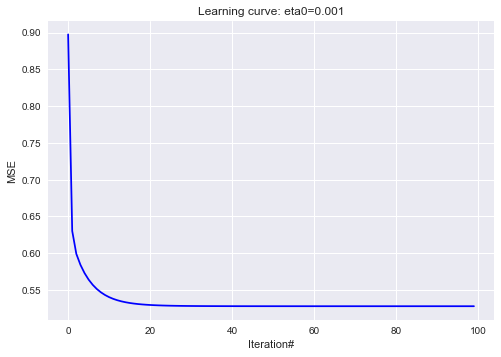

In [30]:
eta0 = 1e-3
sgd_pipeline = Pipeline([("feature_scaling", StandardScaler()),
                             ("sgd", SGDRegressor(max_iter=1, warm_start=True, eta0=eta0, random_state=42))])

loss = []
for epoch in range(100):
    sgd_pipeline.fit(train_features, train_labels)
    loss.append(mean_squared_error(train_labels, sgd_pipeline.predict(train_features)))

plt.plot(np.arange(len(loss)), loss, 'b-')
plt.xlabel('Iteration#')
plt.ylabel('MSE')
plt.title(f'Learning curve: eta0={eta0}')

This is an ideal learning curve as the training loss reduces monotonically, as the training progresses

In [31]:
print("No of iterations before reaching convergence : ", sgd_pipeline[-1].n_iter_)
print("No of weight updates : ", sgd_pipeline[-1].t_)

No of iterations before reaching convergence :  1
No of weight updates :  11611.0


## <a id="FETA0"></a>Finding the best eta0 using `validation_curve`
The `validation_curve()` function determines training and test scores for varying parameter values.

In [33]:
shuffle_split_cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

eta0 = [1e-5, 1e-4, 1e-3, 1e-2]
train_scores, test_scores = validation_curve(sgd_pipeline, com_train_features, com_train_labels, cv=shuffle_split_cv, 
                                             param_name='sgd__eta0', param_range=eta0, scoring='neg_mean_squared_error')
train_errors, test_errors = -train_scores, -test_scores

Text(0.5, 1.0, 'Validation curve for SGD')

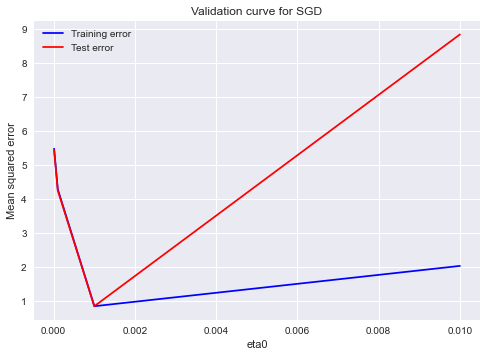

In [34]:
plt.plot(eta0, train_errors.mean(axis=1), 'b-x', label='Training error')
plt.plot(eta0, test_errors.mean(axis=1), 'r-x', label='Test error')
plt.legend()

plt.xlabel('eta0')
plt.ylabel('Mean squared error')
plt.title('Validation curve for SGD')

Since **test error is least** at 0.001, it's the best value for eta0

## <a id="SGDRLR"></a> SGD Regressors With Differnet Types of Learning Rate
Just tweak the `learning_rate` parameter

### SGDRegressor (using the inverse scaling learning rate)

In [56]:
sgd_pipeline = Pipeline([
    ('feature_scaling', StandardScaler()),
    ('sgd', SGDRegressor(max_iter=500, early_stopping=True, eta0=1e-3,tol=1e-3, validation_fraction=0.2, n_iter_no_change=5, average=10, random_state=42))
])

sgd_pipeline.fit(train_features, train_labels)

y_train = train_labels
y_dev = dev_labels
y_pred_train = sgd_pipeline.predict(train_features)
y_pred_dev = sgd_pipeline.predict(dev_features)

train_mae = mean_absolute_error(y_train, y_pred_train)
dev_mae = mean_absolute_error(y_dev, y_pred_dev)
print("Training MAE : ", train_mae)
print("Dev MAE : ", dev_mae)
print("\nNo of iterations before reaching convergence : ", sgd_pipeline[-1].n_iter_)
print("No of weight updates : ", sgd_pipeline[-1].t_)

Training MAE :  0.5433287489797834
Dev MAE :  0.5345612073911922

No of iterations before reaching convergence :  35
No of weight updates :  406351.0


### SGDRegressor (using the constant learning rate)

In [57]:
sgd_pipeline = Pipeline([
    ('feature_scaling', StandardScaler()),
    ('sgd', SGDRegressor(max_iter=500, early_stopping=True, eta0=1e-3,tol=1e-3, validation_fraction=0.2, n_iter_no_change=5, average=10, learning_rate='constant', random_state=42))
])

sgd_pipeline.fit(train_features, train_labels)

y_train = train_labels
y_dev = dev_labels
y_pred_train = sgd_pipeline.predict(train_features)
y_pred_dev = sgd_pipeline.predict(dev_features)

train_mae = mean_absolute_error(y_train, y_pred_train)
dev_mae = mean_absolute_error(y_dev, y_pred_dev)
print("Training MAE : ", train_mae)
print("Dev MAE : ", dev_mae)
print("\nNo of iterations before reaching convergence : ", sgd_pipeline[-1].n_iter_)
print("No of weight updates : ", sgd_pipeline[-1].t_)

Training MAE :  0.5528203432984674
Dev MAE :  0.5689568216133667

No of iterations before reaching convergence :  11
No of weight updates :  127711.0


### SGDRegressor (using the adaptive learning rate)

In [59]:
sgd_pipeline = Pipeline([
    ('feature_scaling', StandardScaler()),
    ('sgd', SGDRegressor(max_iter=500, early_stopping=True, eta0=1e-3,tol=1e-3, validation_fraction=0.2, n_iter_no_change=5, average=10, learning_rate='adaptive', random_state=42))
])

sgd_pipeline.fit(train_features, train_labels)

y_train = train_labels
y_dev = dev_labels
y_pred_train = sgd_pipeline.predict(train_features)
y_pred_dev = sgd_pipeline.predict(dev_features)

train_mae = mean_absolute_error(y_train, y_pred_train)
dev_mae = mean_absolute_error(y_dev, y_pred_dev)
print("Training MAE : ", train_mae)
print("Dev MAE : ", dev_mae)
print("\nNo of iterations before reaching convergence : ", sgd_pipeline[-1].n_iter_)
print("No of weight updates : ", sgd_pipeline[-1].t_)

Training MAE :  0.5375525445454805
Dev MAE :  0.5200254740759911

No of iterations before reaching convergence :  40
No of weight updates :  464401.0


### SGDRegressor (using the constant learning rate and optimum max_iter)

In [60]:
max_iter = np.ceil(1e6 / com_train_features.shape[0])
max_iter

65.0

In [61]:
sgd_pipeline = Pipeline([
    ('feature_scaling', StandardScaler()),
    ('sgd', SGDRegressor(max_iter=max_iter, early_stopping=True, eta0=1e-3,tol=1e-3, validation_fraction=0.2, n_iter_no_change=5, average=10, learning_rate='adaptive', random_state=42))
])

sgd_pipeline.fit(train_features, train_labels)

y_train = train_labels
y_dev = dev_labels
y_pred_train = sgd_pipeline.predict(train_features)
y_pred_dev = sgd_pipeline.predict(dev_features)

train_mae = mean_absolute_error(y_train, y_pred_train)
dev_mae = mean_absolute_error(y_dev, y_pred_dev)
print("Training MAE : ", train_mae)
print("Dev MAE : ", dev_mae)
print("\nNo of iterations before reaching convergence : ", sgd_pipeline[-1].n_iter_)
print("No of weight updates : ", sgd_pipeline[-1].t_)

Training MAE :  0.5375525445454805
Dev MAE :  0.5200254740759911

No of iterations before reaching convergence :  40
No of weight updates :  464401.0
